In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import csv
import random
import numpy as np

import time
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

from tensorflow.keras import backend as K

2025-03-26 14:51:03.727069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-26 14:51:03.727113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-26 14:51:03.727952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 14:51:03.732099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 14:51:04.232618: W tensorflow/compiler/tf2

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Definição do diretório de saída
output_dir = "Trans UNet DICE 5-fold model"
os.makedirs(output_dir, exist_ok=True)  # Garante que a pasta existe

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:20<00:00, 41.50it/s]


In [4]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [5]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [6]:
from tensorflow.keras.layers import (
    Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D,
    Conv2DTranspose, Concatenate, Reshape, Dense, LayerNormalization,
    MultiHeadAttention, Input
)
from tensorflow.keras.models import Model

@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, d_model):
        super(PositionalEmbedding, self).__init__()
        self.pos_emb = self.add_weight(
            shape=(1, num_patches, d_model),
            initializer='zeros',
            trainable=True,
            name='positional_embedding'
        )

    def call(self, inputs):
        return inputs + self.pos_emb

def trans_unet():
    input_shape =  (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    inputs = Input(input_shape)
    
    def conv_block(x, filters, dropout=0.1):
        x = Conv2D(filters, (3, 3), activation='relu', 
                 kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters, (3, 3), activation='relu', 
                 kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return ReLU()(x)
    
    # Encoder (CNN)
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 64, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Transformer Bottleneck
    h = input_shape[0] // 16
    w = input_shape[1] // 16
    num_patches = h * w
    d_model = 256
    
    x = Reshape((num_patches, 128))(p4)
    x = Dense(d_model)(x)
    x = PositionalEmbedding(num_patches, d_model)(x)
    
    # Transformer Encoder
    num_heads = 8
    for _ in range(4):
        x1 = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x1, x1)
        x = attn + x
        x2 = LayerNormalization()(x)
        mlp = Dense(d_model * 4, activation='gelu')(x2)
        mlp = Dense(d_model)(mlp)
        x = mlp + x
    
    x = Reshape((h, w, d_model))(x)
    
    # Decoder (UNet++ style)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, 128)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, 64)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, 32)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, 16)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        f1_score,
        tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
    ])
    
    return model


In [7]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 4

for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i < (fold-1):
        continue
    
    
    print("Fold: " + str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = trans_unet()
    
    
    checkpoint_filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    start_time = time.time()
    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=150, callbacks=callbacks)
    end_time = time.time()
    training_time = end_time - start_time

     # Salvando o tempo de treinamento
    with open(os.path.join(output_dir, 'training_time.txt'), 'a') as f:
        f.write(f'Fold {fold}: {training_time:.2f} segundos\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    with open(os.path.join(output_dir, f'loss_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Epoch", "Loss", "Validation Loss"])
        for epoch, (l, vl) in enumerate(zip(loss, val_loss), start=1):
            writer.writerow([epoch, l, vl])
            
     # Plotando e salvando a figura
    plt.figure()
    plt.plot(loss, 'r', label='Training loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'loss_plot_fold{fold}.png'))
    plt.close()


    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])

        
    del model 

    tf.keras.backend.clear_session()

    fold+=1
    
# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

Fold: 4


2025-03-24 23:28:57.613866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-24 23:28:57.643213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-24 23:28:57.643250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-24 23:28:57.644593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-24 23:28:57.644624: I external/local_xla/xla/stream_executor

Epoch 1/150


2025-03-24 23:29:03.550644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-24 23:29:04.275230: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-24 23:29:08.278949: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1828790272 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 501219328/12878086144
2025-03-24 23:29:08.278990: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10022289408
InUse:                     10531789734
MaxInUse:                  11353891766
NumAllocs:                        1627
MaxAllocSize:               2722250752
Reserved:    

42/42 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.7281 - recall: 0.9564 - precision: 0.0022 - f1_score: 0.0046 - IoU: 0.5026
Epoch 1: val_f1_score improved from -inf to 0.00185, saving model to Trans UNet DICE 5-fold model/model_4fold.keras
42/42 [==============================] - 99s 1s/step - loss: 0.9972 - accuracy: 0.7281 - recall: 0.9564 - precision: 0.0022 - f1_score: 0.0046 - IoU: 0.5026 - val_loss: 0.9982 - val_accuracy: 0.4013 - val_recall: 1.0000 - val_precision: 9.7605e-04 - val_f1_score: 0.0018 - val_IoU: 0.2893
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.9466 - recall: 0.9913 - precision: 0.0117 - f1_score: 0.0420 - IoU: 0.5399
Epoch 2: val_f1_score improved from 0.00185 to 0.00330, saving model to Trans UNet DICE 5-fold model/model_4fold.keras
42/42 [==============================] - 31s 736ms/step - loss: 0.9945 - accuracy: 0.9466 - recall: 0.9913 - precision: 0.0117 - f1_score: 0.0420 - IoU: 0.539

2025-03-25 00:33:15.272228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - ETA: 0s - loss: 0.9973 - accuracy: 0.6799 - recall: 0.9903 - precision: 0.0020 - f1_score: 0.0043 - IoU: 0.5046
Epoch 1: val_f1_score improved from -inf to 0.00168, saving model to Trans UNet DICE 5-fold model/model_5fold.keras
42/42 [==============================] - 31s 518ms/step - loss: 0.9973 - accuracy: 0.6799 - recall: 0.9903 - precision: 0.0020 - f1_score: 0.0043 - IoU: 0.5046 - val_loss: 0.9983 - val_accuracy: 0.3327 - val_recall: 1.0000 - val_precision: 8.9272e-04 - val_f1_score: 0.0017 - val_IoU: 0.2018
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9952 - accuracy: 0.9656 - recall: 0.9931 - precision: 0.0180 - f1_score: 0.0515 - IoU: 0.5387
Epoch 2: val_f1_score improved from 0.00168 to 0.04665, saving model to Trans UNet DICE 5-fold model/model_5fold.keras
42/42 [==============================] - 39s 933ms/step - loss: 0.9952 - accuracy: 0.9656 - recall: 0.9931 - precision: 0.0180 - f1_score: 0.0515 - IoU: 0.

In [8]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

fold = 1
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    model_filepath = filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    model = tf.keras.models.load_model(model_filepath)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])


    fold += 1

# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

k-fold:  20%|███████████████▍                                                             | 1/5 [00:51<03:25, 51.34s/it]/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k-fold:  40%|██████████████████████████████▊                                              | 2/5 [01:42<02:33, 51.00s/it]/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k-fold:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [03:15<00:48, 48.41s/it]/h

Métricas salvas com sucesso na pasta: Trans UNet DICE 5-fold model


In [9]:
print("Accuracy: "+ str(np.mean(acc_total)*100) + " +- " + str(np.std(acc_total)*100))
print("Jaccard: "+ str(np.mean(jacc_total)*100) + " +- " + str(np.std(jacc_total)*100))
print("Dice: "+ str(np.mean(f1_total)*100) + " +- " + str(np.std(f1_total)*100))
print("Precision: "+ str(np.mean(prec_total)*100) + " +- " + str(np.std(prec_total)*100))
print("Recall: "+ str(np.mean(rec_total)*100) + " +- " + str(np.std(rec_total)*100))

Accuracy: 99.9974017963132 +- 0.0009768504968907241
Jaccard: 94.18922478512137 +- 0.5817725841325734
Dice: 96.59768342971802 +- 0.41947118006646633
Precision: 97.022278679358 +- 0.5131467677738468
Recall: 96.68672352455712 +- 0.7697583006408213


In [10]:
best_fold = 2
best_model_filepath = filepath = os.path.join(output_dir, f'model_{best_fold}fold.keras')
best_model = tf.keras.models.load_model(best_model_filepath)

In [11]:
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (best_fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  

1/1 [==============================] - 0s 33ms/step


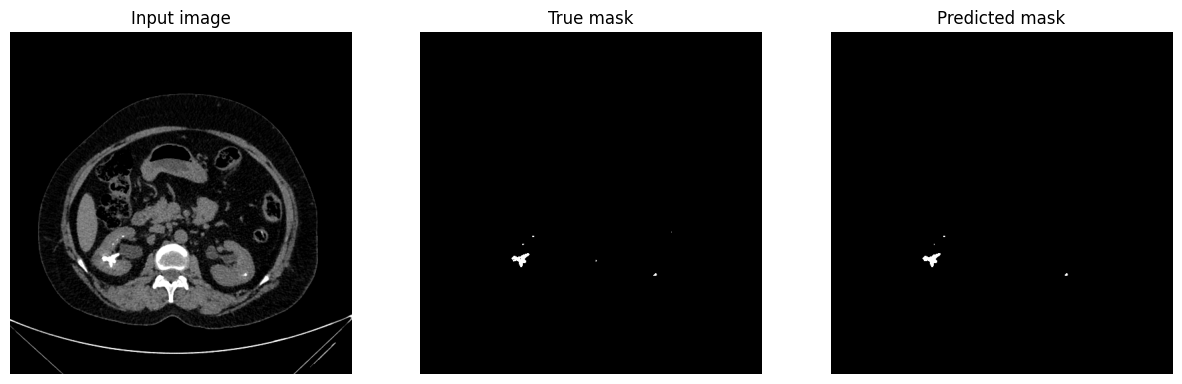

Accuracy: 0.9999427795410156
Jaccard: 0.9460431654676259
Dice: 0.9722735674676526
Precision: 0.9850187265917603
Recall: 0.9598540145985401


In [26]:
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))

In [7]:
model = trans_unet()

2025-03-26 14:51:29.090953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 14:51:29.116493: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 14:51:29.116530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 14:51:29.118428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 14:51:29.118456: I external/local_xla/xla/stream_executor

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['dropout[0][0]']             
                                                                                              